# CNN_Plant_Seedling_Classification


此範例會使用模組化的軟體設計方法，它將一個大型的程式或專案拆分成更小、更容易管理的模塊或組件。每個模塊執行特定的功能或處理特定的任務，並且可以獨立開發、測試和維護。這樣的設計有助於提高程式碼的可讀性、可重用性和可維護性，並且讓不同團隊的開發者能夠協作更輕鬆。在PyTorch中，模組化通常表現為創建獨立的模型、函數和類別，每個模塊負責特定的任務，並且可以輕鬆組合在一起以構建更大的深度學習模型。

本次課程將會把pytorch訓練流程分成以下幾個模組來教學:
1. `Dataset`
2. `Dataloader`
3. `Model`
4. `Train` Function
5. `Valid` Function
6. `Plot Curve` Function
7. `Predict` Function
8. `Main` Function
9. `Addition` Customize model

## Download Datasets

此範例使用kaggle上的[Plant Seedlings Classification](https://www.kaggle.com/c/plant-seedlings-classification)資料集，請先至網站中下載`plant-seedlings-classification.zip`，透過`google.colab`套件，我們可以讓 Colab 上的程式直接讀取自己的雲端硬碟。


執行下面的code之前，請先確保自己的google drive中已經有`plant-seedlings-classification.zip`檔案，並確保檔案位置正確。

掛載自己的google drive後，雲端硬碟的根目錄為: `/content/gdrive/MyDrive/`



In [1]:
import os
data_dir = 'plant-seedlings-classification/'

## Import Package

In [2]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

from torchvision import models
from torchvision.utils import make_grid
from torchvision import transforms as tsfm
from torchvision.datasets import ImageFolder

import random
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image
from pathlib import Path
from IPython import display

# Set random seed for reproducibility
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.backends.cudnn.deterministic = True

## Config
Config of Hyperparameter

In [3]:
# Set Hyperparameters
batch_size = 64
epochs = 50
learning_rate = 0.001
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

## 1. Custom Pytorch Dataset


A `Dataset` in Pytorch should have three methods:

1. `__init__`: Read data & preprocess
2. `__len__`: return a integer indicating the size of the dataset
3. `__getitem__`: given an index `idx`, return the `idx`-th sample

In our case, the download data is structured as:
```
├── train
│   ├── Black-grass (Class name)
│   │   ├── 0050f38b3.png
│   │   ├── 0183fdf68.png
│   │   ├── 0260cffa8.png
│   │   ├── ...
│   └── Charlock
│   │   ├── 022179d65.png
│   │   ├── 02c95e601.png
│   │   ├── 04098447d.png
│   │   ├── ...
│   └── ...
├── test
│   ├── 0021e90e4.png
│   ├── 003d61042.png
│   ├── 007b3da8b.png
│   ├── ...
```

We can simply find all the pngs and load them into memory when needed. In common practice, dataset will receive one or more `torchvision.transforms` which transform the png (loaded as `PIL.Image`) into pytorch tensor.

`Dataloader` batchify the samples in dataset, i.e. builds mini-batch from the data return by dataset's `__getitem__` . We then iterate the `Dataloader` for training.

Usually `Dataloader` is finite and will run of mini-batches when we have seen all samples in `Dataset` once. However, to write our code easily, we can create an infinite `Sampler` that can guide the batchification process in `Dataloader` and make `Dataloader` supply mini-batches infinitely.

In [4]:
class Train_data(Dataset):
    def __init__(self, root_dir, transform=None):
        self.data = ImageFolder(root=root_dir, transform=transform)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, label = self.data[idx]
        return img, label

class Pred_data(Dataset):
    def __init__(self, root_dir, transform=None):
        self.img_paths = list(Path(root_dir).glob('*.png'))
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = Image.open(self.img_paths[idx])
        img = self.transform(img)
        img = img.unsqueeze(0)
        return img

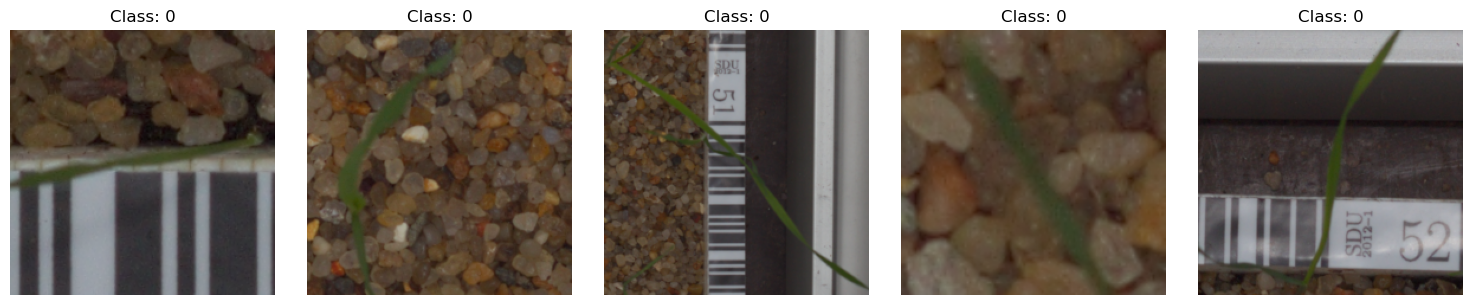

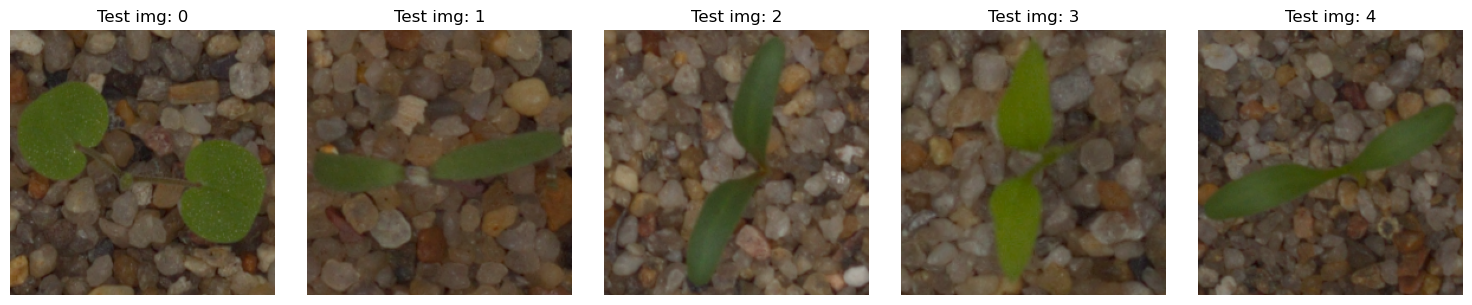

In [5]:
# visualize dataset item for debug
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
transform = tsfm.Compose([
    tsfm.Resize((224, 224)),
    tsfm.ToTensor(),
])

whole_set = Train_data(
    root_dir=train_dir,
    transform=transform
)

test_set = Pred_data(
    root_dir=test_dir,
    transform=transform
)

num_images_to_display = 5
fig, axs = plt.subplots(1, num_images_to_display, figsize=(15, 3))

for i, (img, label) in enumerate(whole_set):
    axs[i].imshow(img.permute(1, 2, 0))
    axs[i].set_title(f'Class: {label}')
    axs[i].axis('off')

    num_images_to_display -= 1
    if num_images_to_display == 0:
        break

plt.tight_layout()
plt.show()

num_images_to_display = 5
fig, axs = plt.subplots(1, num_images_to_display, figsize=(15, 3))
for i, img in enumerate(test_set):
    axs[i].imshow(img[0].permute(1, 2, 0))
    axs[i].set_title(f'Test img: {i}')
    axs[i].axis('off')

    num_images_to_display -= 1
    if num_images_to_display == 0:
        break

plt.tight_layout()
plt.show()

## 2. Split train, valid set and Create Dataloader:


In [6]:
train_set, valid_set = random_split(whole_set, [0.8, 0.2])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size)

## 3. Create Model

A `nn.Module` in Pytorch should have two methods:

1. `__init__`: Initialize your model & define layers
2. `forward`: Compute output of your Model



In [7]:
class resnet_50(nn.Module):
    def __init__(self, num_classes = 12):
        super(resnet_50, self).__init__()
        # pytorch built-in models
        self.resnet50 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

        # set model layers trainable
        for param in self.resnet50.parameters():
            param.requires_grad = True

        # redifine/customize last classification layer
        self.resnet50.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.resnet50(x)
        return x

In [8]:
# test model for debug

model = resnet_50(num_classes=12).cuda()
# print(model)
x = torch.rand(1, 3, 224, 224).cuda()
y = model(x)
print(x)
print(y)

tensor([[[[0.6671, 0.7646, 0.2732,  ..., 0.2299, 0.8501, 0.7446],
          [0.3145, 0.1770, 0.4947,  ..., 0.2657, 0.5151, 0.2777],
          [0.9626, 0.3276, 0.1024,  ..., 0.8075, 0.6732, 0.5020],
          ...,
          [0.1053, 0.0563, 0.9618,  ..., 0.0177, 0.8644, 0.9249],
          [0.2369, 0.6065, 0.7551,  ..., 0.8097, 0.0856, 0.5755],
          [0.6274, 0.9982, 0.7637,  ..., 0.2613, 0.3500, 0.0402]],

         [[0.5232, 0.1650, 0.3030,  ..., 0.7249, 0.3848, 0.7339],
          [0.5719, 0.4828, 0.7574,  ..., 0.5348, 0.9477, 0.0841],
          [0.2502, 0.2524, 0.9801,  ..., 0.1184, 0.5851, 0.6820],
          ...,
          [0.9749, 0.6790, 0.7742,  ..., 0.9642, 0.1267, 0.7451],
          [0.0856, 0.5820, 0.4309,  ..., 0.6179, 0.5303, 0.8151],
          [0.7269, 0.7204, 0.1821,  ..., 0.2500, 0.2649, 0.3273]],

         [[0.0077, 0.6897, 0.1437,  ..., 0.5420, 0.3801, 0.0750],
          [0.3946, 0.1692, 0.3127,  ..., 0.4402, 0.9574, 0.0358],
          [0.8982, 0.4166, 0.9354,  ..., 0

## 4. Define Train Function(for one epoch):


In [9]:
def train(model, criterion, optimizer, train_loader, epoch, total_epochs, batch_size):
    model.train()
    train_loss, train_acc = [], []

    tqdm_iter = tqdm(train_loader, desc="Epoch: {}/{} ({}%) | Training loss: NaN".format(
    epoch, total_epochs, int(epoch/total_epochs * 100)), leave=False)
    epoch_loss, epoch_acc = 0.0, 0.0
    for batch_idx, (data, label) in enumerate(tqdm_iter):
        data, target = data.cuda(), label.cuda()
        output = model(data)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == target).float().mean().item()
        epoch_loss += loss.item()
        epoch_acc += acc

        tqdm_iter.set_description("Epoch: {}/{} ({}%) | Training loss: {:.6f} | Training Acc: {:.6f}".format(
        epoch + 1, total_epochs, int((epoch+1)/total_epochs * 100), round(loss.item(), 6), round(acc, 6)))

    return epoch_loss / len(train_loader), epoch_acc / len(train_loader)

In [10]:
# debug "train" function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

loss, acc = train(
    model,
    criterion,
    optimizer,
    train_loader,
    epoch=1,
    total_epochs=1,
    batch_size=batch_size
)

print(loss, acc)

Epoch: 1/1 (100%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

2.056841818491618 0.32013888905445737


## 5. Define Valid Function(for one epoch):


In [11]:
def valid(model, criterion, valid_loader, epoch, total_epochs, batch_size):
    model.eval()

    tqdm_iter = tqdm(valid_loader, desc="Epoch: {}/{} ({}%) | Valid loss: NaN".format(
    epoch, total_epochs, int(epoch/total_epochs * 100)), leave=False)
    epoch_loss, epoch_acc = 0.0, 0.0
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(tqdm_iter):
            data, target = data.cuda(), label.cuda()
            output = model(data)
            loss = criterion(output, target)
            acc = (output.argmax(dim=1) == target).float().mean().item()
            epoch_loss += loss.item()
            epoch_acc += acc

            tqdm_iter.set_description("Epoch: {}/{} ({}%) | Valid loss: {:.6f} | Valid Acc: {:.6f}".format(
            epoch + 1, total_epochs, int((epoch+1)/total_epochs * 100), round(loss.item(), 6), round(acc, 6)))

    return epoch_loss / len(valid_loader), epoch_acc / len(valid_loader)

In [12]:
# debug "valid" function
criterion = nn.CrossEntropyLoss()
loss, acc = valid(
    model,
    criterion,
    valid_loader,
    epoch=1,
    total_epochs=1,
    batch_size=batch_size
)

print(loss, acc)

Epoch: 1/1 (100%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

5.6482525825500485 0.37754629651705424


## 6. Plot Learning Curve Function:

In [13]:
def Plot(title, ylabel, epochs, train_loss, valid_loss):
    plt.figure()
    plt.title(title)
    plt.xlabel('epochs')
    plt.ylabel(ylabel)
    plt.plot(epochs, train_loss)
    plt.plot(epochs, valid_loss)
    plt.legend(['train', 'valid'], loc='upper left')

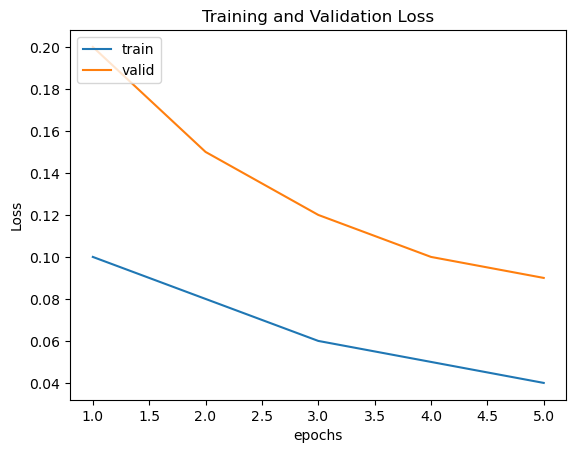

In [14]:
# debug "Plot" function
debug_epochs = [1, 2, 3, 4, 5]
debug_train_loss = [0.1, 0.08, 0.06, 0.05, 0.04]
debug_valid_loss = [0.2, 0.15, 0.12, 0.1, 0.09]

Plot("Training and Validation Loss", 'Loss', debug_epochs, debug_train_loss, debug_valid_loss)

plt.show()

## 7. Predict Function:

In [15]:
def predict(loader, model):
    model.eval()
    preds = []
    for data in tqdm(loader):
        pred = model(data.cuda())
        cls = torch.argmax(pred, dim=1)
        preds.append(cls)

    return preds

In [16]:
# Visualize Predict result
def view_pred_result(preds, num_images_to_display=5):
    labels = ['Black-grass', 'Charlock' , 'Cleavers' , 'Common Chickweed' , 'Common wheat' , 'Fat Hen' , 'Loose Silky-bent' , 'Maize' , 'Scentless Mayweed' , 'Shepherds Purse', 'Small-flowered Cranesbill' , 'Sugar beet']
    fig, axs = plt.subplots(1, num_images_to_display, figsize=(15, 3))
    for i, img in enumerate(test_set):
        axs[i].imshow(img[0].permute(1, 2, 0))
        axs[i].set_title(labels[preds[i].item()])
        axs[i].axis('off')

        num_images_to_display -= 1
        if num_images_to_display == 0:
            break

    plt.tight_layout()
    plt.show()

  0%|          | 0/794 [00:00<?, ?it/s]

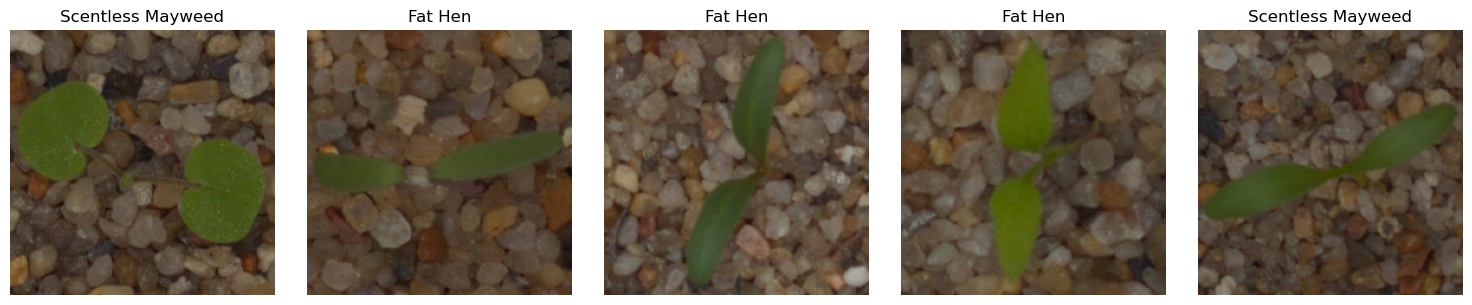

In [17]:
# debug "Predict" function & "View_Predict_result" function
test_dir = os.path.join(data_dir, 'test')
transform = tsfm.Compose([
    tsfm.Resize((224, 224)),
    tsfm.ToTensor(),
])
test_set = Pred_data(
    root_dir=test_dir,
    transform=transform
)
model = resnet_50(num_classes=12).cuda()

preds = predict(test_set, model)
view_pred_result(preds)

## 8. Main Function(training pipeline):
1. `Set Hyperparameters`: `batct_size`, `learning rate`, `epochs`...
2. `Initial`: initial `dataset`, `dataloader`, `model`
3. `Train`: Do train
4. `Valid`: Do valid
5. repeat `3.`  `4.` epochs times
6. `Plot curve`: Plot learning curve to observe the learning progress
7. `Predict`: Use the trained model to predict the results of the test set

50
epoch: 1/50


Epoch: 0/50 (0%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.7538131281733513, Avg train acc: 0.7607638895511627


Epoch: 0/50 (0%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.41876884003480275, Avg valid acc: 0.8594521601994832
epoch: 2/50


Epoch: 1/50 (2%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.26565192031363644, Avg train acc: 0.9084201395511627


Epoch: 1/50 (2%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 1.080553364753723, Avg valid acc: 0.7227623462677002
epoch: 3/50


Epoch: 2/50 (4%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.17043028883635997, Avg train acc: 0.9421006947755813


Epoch: 2/50 (4%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.24690924684206644, Avg valid acc: 0.9059413592020671
epoch: 4/50


Epoch: 3/50 (6%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.16415145390977462, Avg train acc: 0.942534722884496


Epoch: 3/50 (6%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.27938150068124135, Avg valid acc: 0.8978009263674418
epoch: 5/50


Epoch: 4/50 (8%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.09815557113227745, Avg train acc: 0.9684895833333333


Epoch: 4/50 (8%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.36713312367598216, Avg valid acc: 0.893248458703359
epoch: 6/50


Epoch: 5/50 (10%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.0749198074452579, Avg train acc: 0.9763888895511628


Epoch: 5/50 (10%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.3850702534119288, Avg valid acc: 0.9054783940315246
epoch: 7/50


Epoch: 6/50 (12%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.050253141880966724, Avg train acc: 0.980642361442248


Epoch: 6/50 (12%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.34219685196876526, Avg valid acc: 0.9125771601994832
epoch: 8/50


Epoch: 7/50 (14%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.09266883203526959, Avg train acc: 0.9703993062178294


Epoch: 7/50 (14%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.4575316826502482, Avg valid acc: 0.866435186068217
epoch: 9/50


Epoch: 8/50 (16%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.06384840167593211, Avg train acc: 0.9789930562178294


Epoch: 8/50 (16%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.17771099309126537, Avg valid acc: 0.9462962985038758
epoch: 10/50


Epoch: 9/50 (18%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.035896194487577304, Avg train acc: 0.9901041666666667


Epoch: 9/50 (18%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.21503532168765863, Avg valid acc: 0.951504631837209
epoch: 11/50


Epoch: 10/50 (20%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.0757832288237599, Avg train acc: 0.9765625


Epoch: 10/50 (20%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.6155312836170197, Avg valid acc: 0.8534722208976746
epoch: 12/50


Epoch: 11/50 (22%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.06757414996003111, Avg train acc: 0.980034722884496


Epoch: 11/50 (22%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.2410365718106429, Avg valid acc: 0.9319058656692505
epoch: 13/50


Epoch: 12/50 (24%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.026517349102262718, Avg train acc: 0.9927951395511627


Epoch: 12/50 (24%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.20191176980733871, Avg valid acc: 0.9431712985038757
epoch: 14/50


Epoch: 13/50 (26%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.017222054543284078, Avg train acc: 0.99453125


Epoch: 13/50 (26%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.21687875141700108, Avg valid acc: 0.9421296318372091
epoch: 15/50


Epoch: 14/50 (28%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.019629622789216226, Avg train acc: 0.9940972228844961


Epoch: 14/50 (28%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.16920677895347278, Avg valid acc: 0.9527391990025839
epoch: 16/50


Epoch: 15/50 (30%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.028924230977039164, Avg train acc: 0.99296875


Epoch: 15/50 (30%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.4547934701045354, Avg valid acc: 0.8802854935328166
epoch: 17/50


Epoch: 16/50 (32%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.057968508253300875, Avg train acc: 0.981423611442248


Epoch: 16/50 (32%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.29624617596467334, Avg valid acc: 0.9078317920366923
epoch: 18/50


Epoch: 17/50 (34%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.06803799070573101, Avg train acc: 0.9786458333333333


Epoch: 17/50 (34%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.3663105328877767, Avg valid acc: 0.9096450606981913
epoch: 19/50


Epoch: 18/50 (36%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.03749967805827813, Avg train acc: 0.9890625


Epoch: 18/50 (36%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.3119679401318232, Avg valid acc: 0.920061727364858
epoch: 20/50


Epoch: 19/50 (38%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.027563791171026728, Avg train acc: 0.9896701395511627


Epoch: 19/50 (38%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.22763218581676484, Avg valid acc: 0.9393904328346252
epoch: 21/50


Epoch: 20/50 (40%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.014518632487549137, Avg train acc: 0.9958333333333333


Epoch: 20/50 (40%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.2395090313007434, Avg valid acc: 0.9527391990025839
epoch: 22/50


Epoch: 21/50 (42%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.045153717070934365, Avg train acc: 0.9854166666666667


Epoch: 21/50 (42%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.18344163944323857, Avg valid acc: 0.9429783940315246
epoch: 23/50


Epoch: 22/50 (44%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.015271539915314254, Avg train acc: 0.9955729166666667


Epoch: 22/50 (44%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.18648215085268022, Avg valid acc: 0.9558641990025838
epoch: 24/50


Epoch: 23/50 (46%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.0028423711301002186, Avg train acc: 0.9994791666666667


Epoch: 23/50 (46%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.15521847742299238, Avg valid acc: 0.9621141990025838
epoch: 25/50


Epoch: 24/50 (48%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.001211872135536396, Avg train acc: 0.9997395833333333


Epoch: 24/50 (48%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.16264849714934826, Avg valid acc: 0.9640046318372091
epoch: 26/50


Epoch: 25/50 (50%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.0006731327374533673, Avg train acc: 0.9994791666666667


Epoch: 25/50 (50%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.1758820444345474, Avg valid acc: 0.9610725323359172
epoch: 27/50


Epoch: 26/50 (52%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.0004202308036838076, Avg train acc: 0.9997395833333333


Epoch: 26/50 (52%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.17713815520207088, Avg valid acc: 0.9619212985038758
epoch: 28/50


Epoch: 27/50 (54%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.00039719910957198104, Avg train acc: 1.0


Epoch: 27/50 (54%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.18086020946502684, Avg valid acc: 0.9629629651705424
epoch: 29/50


Epoch: 28/50 (56%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.00012335443964275327, Avg train acc: 1.0


Epoch: 28/50 (56%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.1853405497968197, Avg valid acc: 0.9640046318372091
epoch: 30/50


Epoch: 29/50 (57%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 8.455496420841276e-05, Avg train acc: 1.0


Epoch: 29/50 (57%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.18556096653143564, Avg valid acc: 0.9640046318372091
epoch: 31/50


Epoch: 30/50 (60%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 6.173084445132796e-05, Avg train acc: 1.0


Epoch: 30/50 (60%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.1868173191944758, Avg valid acc: 0.9629629651705424
epoch: 32/50


Epoch: 31/50 (62%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 6.757671486260128e-05, Avg train acc: 1.0


Epoch: 31/50 (62%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.18490650206804277, Avg valid acc: 0.9640046318372091
epoch: 33/50


Epoch: 32/50 (64%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 4.1563379954823174e-05, Avg train acc: 1.0


Epoch: 32/50 (64%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.1893799975514412, Avg valid acc: 0.9619212985038758
epoch: 34/50


Epoch: 33/50 (66%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 6.526525216941082e-05, Avg train acc: 1.0


Epoch: 33/50 (66%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.18132094144821168, Avg valid acc: 0.9650462985038757
epoch: 35/50


Epoch: 34/50 (68%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 7.747740863427074e-05, Avg train acc: 1.0


Epoch: 34/50 (68%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.1782861515879631, Avg valid acc: 0.9650462985038757
epoch: 36/50


Epoch: 35/50 (70%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 4.411305957698157e-05, Avg train acc: 1.0


Epoch: 35/50 (70%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.18296569113930067, Avg valid acc: 0.9650462985038757
epoch: 37/50


Epoch: 36/50 (72%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.0008909526186622922, Avg train acc: 0.9993055562178293


Epoch: 36/50 (72%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.17930208208660284, Avg valid acc: 0.9650462985038757
epoch: 38/50


Epoch: 37/50 (74%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.05990355247158732, Avg train acc: 0.9848090281089147


Epoch: 37/50 (74%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.7197459518909455, Avg valid acc: 0.8265817920366924
epoch: 39/50


Epoch: 38/50 (76%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.18310235179960727, Avg train acc: 0.9421875


Epoch: 38/50 (76%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.6597066501776377, Avg valid acc: 0.8314043203989665
epoch: 40/50


Epoch: 39/50 (78%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.10906087957943479, Avg train acc: 0.9639756947755813


Epoch: 39/50 (78%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.1997894451022148, Avg valid acc: 0.9330246925354004
epoch: 41/50


Epoch: 40/50 (80%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.03490660704749947, Avg train acc: 0.9895833333333334


Epoch: 40/50 (80%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.43486360609531405, Avg valid acc: 0.902816359202067
epoch: 42/50


Epoch: 41/50 (82%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.016089811544225084, Avg train acc: 0.9947916666666666


Epoch: 41/50 (82%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.21309709250926973, Avg valid acc: 0.9494212985038757
epoch: 43/50


Epoch: 42/50 (84%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.011268099347459308, Avg train acc: 0.996875


Epoch: 42/50 (84%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.2491581327902774, Avg valid acc: 0.9405092597007751
epoch: 44/50


Epoch: 43/50 (86%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.007361363471136429, Avg train acc: 0.9979166666666667


Epoch: 43/50 (86%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.18530682288110256, Avg valid acc: 0.9556712985038758
epoch: 45/50


Epoch: 44/50 (88%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.001433543259796958, Avg train acc: 0.9997395833333333


Epoch: 44/50 (88%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.181549454977115, Avg valid acc: 0.9627700606981914
epoch: 46/50


Epoch: 45/50 (90%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.000428485971375873, Avg train acc: 1.0


Epoch: 45/50 (90%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.18783725785712402, Avg valid acc: 0.960879631837209
epoch: 47/50


Epoch: 46/50 (92%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.001112561787370699, Avg train acc: 0.9993055562178293


Epoch: 46/50 (92%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.18689975840970874, Avg valid acc: 0.9673225323359171
epoch: 48/50


Epoch: 47/50 (94%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.006410870604850061, Avg train acc: 0.9986979166666666


Epoch: 47/50 (94%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.2145159219702085, Avg valid acc: 0.9494212985038757
epoch: 49/50


Epoch: 48/50 (96%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.01782507512665082, Avg train acc: 0.9950520833333333


Epoch: 48/50 (96%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.6056462824344635, Avg valid acc: 0.8376543203989665
epoch: 50/50


Epoch: 49/50 (98%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.04340006966182652, Avg train acc: 0.9869791666666666


Epoch: 49/50 (98%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.3141682999829451, Avg valid acc: 0.9172067920366923


  0%|          | 0/794 [00:00<?, ?it/s]

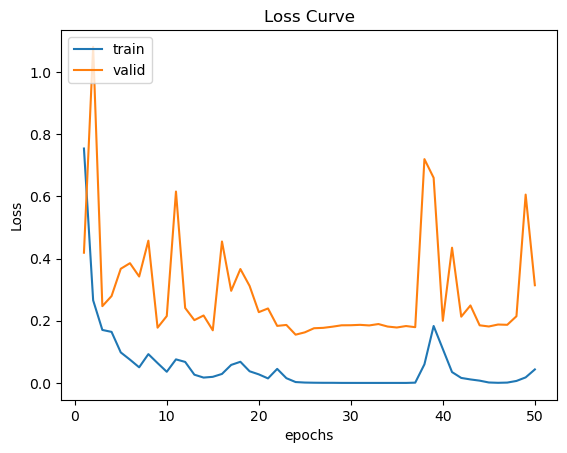

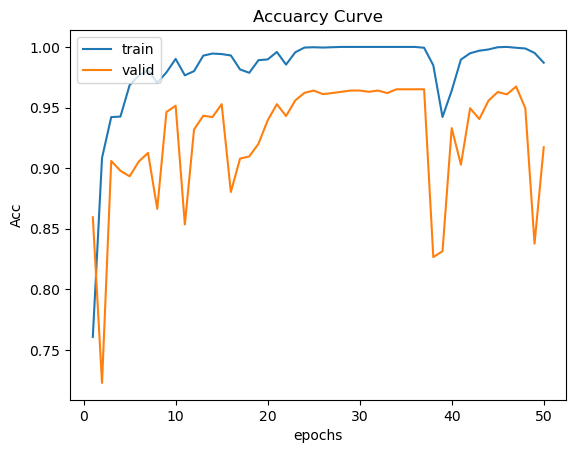

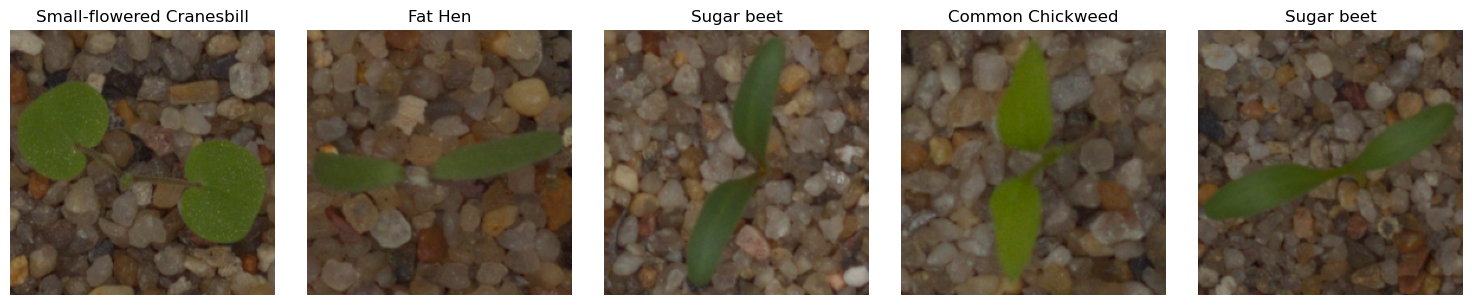

In [18]:
def main():
    # initial transform
    transform = tsfm.Compose([
        tsfm.Resize((224, 224)),
        tsfm.ToTensor(),
    ])

    # initial dataset
    whole_set = Train_data(
        root_dir=train_dir,
        transform=transform
    )

    test_set = Pred_data(
        root_dir=test_dir,
        transform=transform
    )

    # split train valid and initial dataloader
    train_set_size = int(len(whole_set) * 0.8)
    valid_set_size = len(whole_set) - train_set_size
    train_set, valid_set = random_split(whole_set, [train_set_size, valid_set_size])

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_set, batch_size=batch_size)

    # initial model
    model = resnet_50(num_classes=12).cuda()

    # initial loss_function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # initial plot values
    train_loss, train_acc = [], []
    valid_loss, valid_acc = [], []
    epoch_list = []

    # repeat train and valid epochs times
    print(epochs)
    for epoch in range(epochs):
      epoch_list.append(epoch + 1)
      print(f'epoch: {epoch+1}/{epochs}')
      loss, acc = train(
          model,
          criterion,
          optimizer,
          train_loader,
          epoch=epoch,
          total_epochs=epochs,
          batch_size=batch_size
      )
      train_loss.append(loss)
      train_acc.append(acc)
      print(f'Avg train Loss: {loss}, Avg train acc: {acc}')

      loss, acc = valid(
          model,
          criterion,
          valid_loader,
          epoch=epoch,
          total_epochs=epochs,
          batch_size=batch_size
      )
      valid_loss.append(loss)
      valid_acc.append(acc)
      print(f'Avg valid Loss: {loss}, Avg valid acc: {acc}')

    Plot("Loss Curve", 'Loss', epoch_list, train_loss, valid_loss)
    Plot("Accuarcy Curve", 'Acc', epoch_list, train_acc, valid_acc)

    preds = predict(test_set, model)
    view_pred_result(preds)

main()

## 9. Addition: Customize your own model
Create your own deep learning model, by define the inner layers in hand-craft<br>
Example for VGG16 model: https://arxiv.org/abs/1409.1556

In [19]:
class VGG16(nn.Module):
    def __init__(self, num_classes=12):
        super(VGG16, self).__init__()
        # input layer
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())

        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        #  classifier
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU()
        )

        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU()
        )

        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [20]:
# Test model to debug
x = torch.rand(1, 3, 224, 224)
model = VGG16(num_classes=12)
y = model(x)
print(y)

tensor([[ 0.0544,  0.0935, -0.3623,  0.1592,  0.4364, -0.1581,  0.0165,  0.1234,
         -0.3171,  0.2277,  0.0502,  0.2483]], grad_fn=<AddmmBackward0>)


Rerun training for VGG16 model

50
epoch: 0/50


Epoch: 0/50 (0%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 5.027532084782918, Avg train acc: 0.10989583333333333


Epoch: 0/50 (0%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 2.411981773376465, Avg valid acc: 0.1335648149251938
epoch: 1/50


Epoch: 1/50 (2%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 2.435644539197286, Avg train acc: 0.14887152810891469


Epoch: 1/50 (2%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 2.1867792924245197, Avg valid acc: 0.24409722288449606
epoch: 2/50


Epoch: 2/50 (4%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 2.22614506483078, Avg train acc: 0.22864583333333333


Epoch: 2/50 (4%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 1.9910163720448812, Avg valid acc: 0.3233796298503876
epoch: 3/50


Epoch: 3/50 (6%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 2.0742061118284862, Avg train acc: 0.2864583333333333


Epoch: 3/50 (6%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 1.8556188821792603, Avg valid acc: 0.3638117293516795
epoch: 4/50


Epoch: 4/50 (8%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 1.938707749048869, Avg train acc: 0.30633680572112404


Epoch: 4/50 (8%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 1.7390843947728476, Avg valid acc: 0.42310956716537473
epoch: 5/50


Epoch: 5/50 (10%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 1.8211046040058136, Avg train acc: 0.347048611442248


Epoch: 5/50 (10%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 1.6208287080128987, Avg valid acc: 0.44089506268501283
epoch: 6/50


Epoch: 6/50 (12%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 1.760825894276301, Avg train acc: 0.37005208333333334


Epoch: 6/50 (12%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 1.5450326522191367, Avg valid acc: 0.4724537054697672
epoch: 7/50


Epoch: 7/50 (14%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 1.7182318071524303, Avg train acc: 0.3944444447755814


Epoch: 7/50 (14%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 1.5748627503712973, Avg valid acc: 0.47376543283462524
epoch: 8/50


Epoch: 8/50 (16%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 1.6502885321776073, Avg train acc: 0.41848958333333336


Epoch: 8/50 (16%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 1.56682239373525, Avg valid acc: 0.521875
epoch: 9/50


Epoch: 9/50 (18%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 1.677929844458898, Avg train acc: 0.40763888905445733


Epoch: 9/50 (18%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 1.5613670587539672, Avg valid acc: 0.5012345671653747
epoch: 10/50


Epoch: 10/50 (20%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 1.5781598130861918, Avg train acc: 0.44331597288449603


Epoch: 10/50 (20%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 1.5470586856206259, Avg valid acc: 0.5087191343307496
epoch: 11/50


Epoch: 11/50 (22%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 1.5461779216925302, Avg train acc: 0.44765625


Epoch: 11/50 (22%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 1.3658612728118897, Avg valid acc: 0.5469907402992249
epoch: 12/50


Epoch: 12/50 (24%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 1.5103723963101705, Avg train acc: 0.4629340281089147


Epoch: 12/50 (24%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 1.2969898541768392, Avg valid acc: 0.5855324069658915
epoch: 13/50


Epoch: 13/50 (26%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 1.4591188371181487, Avg train acc: 0.4822916666666667


Epoch: 13/50 (26%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 1.3626688321431477, Avg valid acc: 0.5653549393018087
epoch: 14/50


Epoch: 14/50 (28%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 1.46040025750796, Avg train acc: 0.479774305721124


Epoch: 14/50 (28%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 1.3516992171605429, Avg valid acc: 0.56138117313385
epoch: 15/50


Epoch: 15/50 (30%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 1.412394654750824, Avg train acc: 0.48967013905445733


Epoch: 15/50 (30%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 1.2048007249832153, Avg valid acc: 0.5984182119369507
epoch: 16/50


Epoch: 16/50 (32%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 1.3513126214345297, Avg train acc: 0.5153645833333333


Epoch: 16/50 (32%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 1.3376317183176676, Avg valid acc: 0.5476466059684754
epoch: 17/50


Epoch: 17/50 (34%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 1.3890844404697418, Avg train acc: 0.5002604166666667


Epoch: 17/50 (34%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 1.1947328726450601, Avg valid acc: 0.6144290129343669
epoch: 18/50


Epoch: 18/50 (36%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 1.3129788835843403, Avg train acc: 0.5197916666666667


Epoch: 18/50 (36%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 1.4873989502588907, Avg valid acc: 0.49290123383204143
epoch: 19/50


Epoch: 19/50 (38%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 1.3293356994787853, Avg train acc: 0.5241319447755813


Epoch: 19/50 (38%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 1.2549466848373414, Avg valid acc: 0.6084490736325582
epoch: 20/50


Epoch: 20/50 (40%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 1.283893772959709, Avg train acc: 0.536111111442248


Epoch: 20/50 (40%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 1.4257927497227987, Avg valid acc: 0.5151620388031006
epoch: 21/50


Epoch: 21/50 (42%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 1.285483964284261, Avg train acc: 0.5302083333333333


Epoch: 21/50 (42%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 1.15680251121521, Avg valid acc: 0.6258873462677002
epoch: 22/50


Epoch: 22/50 (44%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 1.2399047940969468, Avg train acc: 0.5527777781089147


Epoch: 22/50 (44%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 1.1987327655156454, Avg valid acc: 0.6271990736325582
epoch: 23/50


Epoch: 23/50 (46%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 1.2174026181300481, Avg train acc: 0.559548611442248


Epoch: 23/50 (46%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 1.186195707321167, Avg valid acc: 0.653433640797933
epoch: 24/50


Epoch: 24/50 (48%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 1.2013944149017335, Avg train acc: 0.5621527781089147


Epoch: 24/50 (48%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 1.1579346497853598, Avg valid acc: 0.625501545270284
epoch: 25/50


Epoch: 25/50 (50%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 1.1949637164672215, Avg train acc: 0.568923611442248


Epoch: 25/50 (50%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 1.3938936312993369, Avg valid acc: 0.5003858009974161
epoch: 26/50


Epoch: 26/50 (52%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 1.182970447341601, Avg train acc: 0.5671875


Epoch: 26/50 (52%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 1.180029034614563, Avg valid acc: 0.6168981472651164
epoch: 27/50


Epoch: 27/50 (54%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 1.1266233801841736, Avg train acc: 0.588454861442248


Epoch: 27/50 (54%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 1.1258612791697185, Avg valid acc: 0.6464506189028422
epoch: 28/50


Epoch: 28/50 (56%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 1.130275046825409, Avg train acc: 0.5881076395511627


Epoch: 28/50 (56%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 1.0846428434054056, Avg valid acc: 0.6266589522361755
epoch: 29/50


Epoch: 29/50 (57%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 1.1209453831116358, Avg train acc: 0.6013888890544573


Epoch: 29/50 (57%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 1.0712668855985006, Avg valid acc: 0.6613040129343669
epoch: 30/50


Epoch: 30/50 (60%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 1.0671662946542104, Avg train acc: 0.6199652781089147


Epoch: 30/50 (60%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 1.2934088150660197, Avg valid acc: 0.5072916666666667
epoch: 31/50


Epoch: 31/50 (62%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 1.097228823105494, Avg train acc: 0.60546875


Epoch: 31/50 (62%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 1.3250670909881592, Avg valid acc: 0.5670524676640828
epoch: 32/50


Epoch: 32/50 (64%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 1.044155526161194, Avg train acc: 0.6294270833333333


Epoch: 32/50 (64%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 1.089368422826131, Avg valid acc: 0.6565586407979329
epoch: 33/50


Epoch: 33/50 (66%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 1.057164787252744, Avg train acc: 0.6244791666666667


Epoch: 33/50 (66%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.981022298336029, Avg valid acc: 0.6906635800997416
epoch: 34/50


Epoch: 34/50 (68%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 1.0712950468063354, Avg train acc: 0.6209201395511628


Epoch: 34/50 (68%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 1.1321676890055339, Avg valid acc: 0.6592206796010335
epoch: 35/50


Epoch: 35/50 (70%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 1.0183232059081395, Avg train acc: 0.6389756947755814


Epoch: 35/50 (70%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 1.1101152737935385, Avg valid acc: 0.6419753074645996
epoch: 36/50


Epoch: 36/50 (72%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 1.0391512324412664, Avg train acc: 0.6246527781089147


Epoch: 36/50 (72%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 1.2680806477864583, Avg valid acc: 0.5956790129343669
epoch: 37/50


Epoch: 37/50 (74%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 1.049978964527448, Avg train acc: 0.626128472884496


Epoch: 37/50 (74%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 1.231872320175171, Avg valid acc: 0.5944444457689921
epoch: 38/50


Epoch: 38/50 (76%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 1.0234346131483714, Avg train acc: 0.635329861442248


Epoch: 38/50 (76%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 1.329982614517212, Avg valid acc: 0.5380787054697672
epoch: 39/50


Epoch: 39/50 (78%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.9345001896222432, Avg train acc: 0.6691840281089146


Epoch: 39/50 (78%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 1.4425501028696697, Avg valid acc: 0.5520833333333334
epoch: 40/50


Epoch: 40/50 (80%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.9334129681189854, Avg train acc: 0.671440972884496


Epoch: 40/50 (80%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.9284013152122498, Avg valid acc: 0.7094135800997416
epoch: 41/50


Epoch: 41/50 (82%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.9301520665486653, Avg train acc: 0.684722222884496


Epoch: 41/50 (82%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.8915668884913127, Avg valid acc: 0.741435186068217
epoch: 42/50


Epoch: 42/50 (84%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.930459263920784, Avg train acc: 0.6835069447755814


Epoch: 42/50 (84%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 1.1270211935043335, Avg valid acc: 0.634876545270284
epoch: 43/50


Epoch: 43/50 (86%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.9149514178435008, Avg train acc: 0.6807291666666667


Epoch: 43/50 (86%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.938779350121816, Avg valid acc: 0.6900848786036173
epoch: 44/50


Epoch: 44/50 (88%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.9174135357141495, Avg train acc: 0.6821180562178294


Epoch: 44/50 (88%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 1.322871200243632, Avg valid acc: 0.5859953721364339
epoch: 45/50


Epoch: 45/50 (90%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.8546501745780309, Avg train acc: 0.7071180562178294


Epoch: 45/50 (90%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.8332487781842549, Avg valid acc: 0.7568672855695089
epoch: 46/50


Epoch: 46/50 (92%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.8901436726252238, Avg train acc: 0.69609375


Epoch: 46/50 (92%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.9660866657892863, Avg valid acc: 0.6867669741312663
epoch: 47/50


Epoch: 47/50 (94%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.8170250376065572, Avg train acc: 0.71484375


Epoch: 47/50 (94%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.8222677826881408, Avg valid acc: 0.7592206796010336
epoch: 48/50


Epoch: 48/50 (96%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.8003593569000562, Avg train acc: 0.719704861442248


Epoch: 48/50 (96%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.886102044582367, Avg valid acc: 0.7285493850708008
epoch: 49/50


Epoch: 49/50 (98%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.7979660977919897, Avg train acc: 0.7155381947755813


Epoch: 49/50 (98%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.7481691082318623, Avg valid acc: 0.7528935194015502


  0%|          | 0/794 [00:00<?, ?it/s]

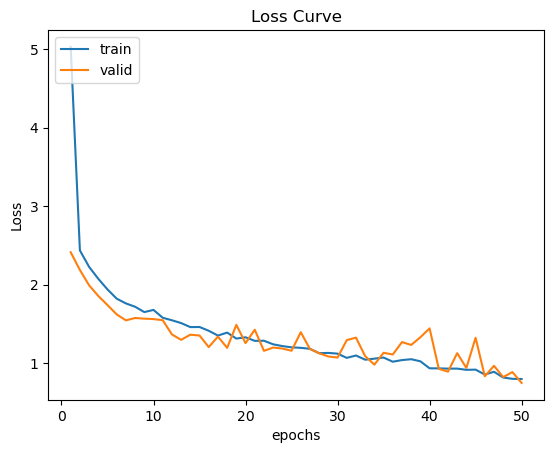

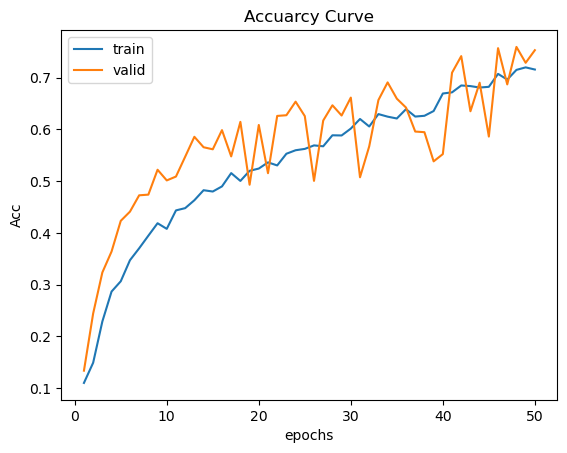

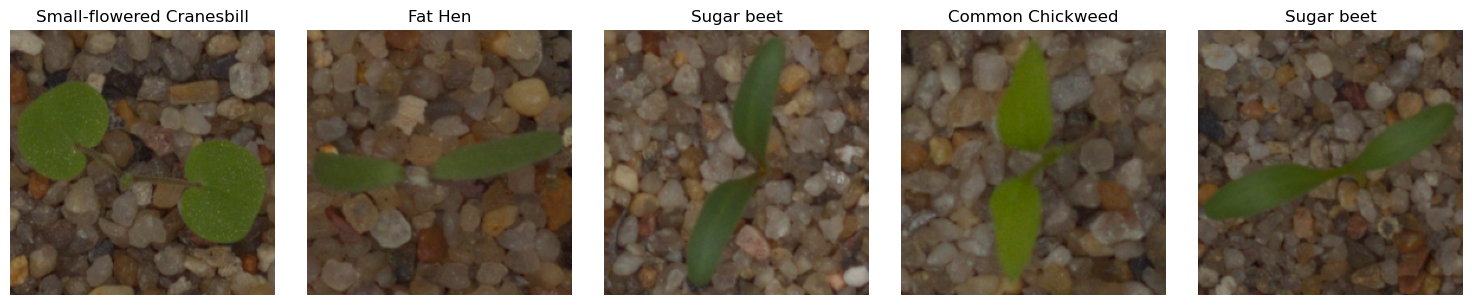

In [21]:
def main():
    # initial transform
    transform = tsfm.Compose([
        tsfm.Resize((224, 224)),
        tsfm.ToTensor(),
    ])

    # initial dataset
    whole_set = Train_data(
        root_dir=train_dir,
        transform=transform
    )

    test_set = Pred_data(
        root_dir=test_dir,
        transform=transform
    )

    # split train valid and initial dataloader
    train_set_size = int(len(whole_set) * 0.8)
    valid_set_size = len(whole_set) - train_set_size
    train_set, valid_set = random_split(whole_set, [train_set_size, valid_set_size])

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_set, batch_size=batch_size)

    # initial model
    model = VGG16(num_classes=12).cuda()

    # initial loss_function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # initial plot values
    train_loss, train_acc = [], []
    valid_loss, valid_acc = [], []
    epoch_list = []

    # repeat train and valid epochs times
    print(epochs)
    for epoch in range(epochs):
      epoch_list.append(epoch + 1)
      print(f'epoch: {epoch}/{epochs}')
      loss, acc = train(
          model,
          criterion,
          optimizer,
          train_loader,
          epoch=epoch,
          total_epochs=epochs,
          batch_size=batch_size
      )
      train_loss.append(loss)
      train_acc.append(acc)
      print(f'Avg train Loss: {loss}, Avg train acc: {acc}')

      loss, acc = valid(
          model,
          criterion,
          valid_loader,
          epoch=epoch,
          total_epochs=epochs,
          batch_size=batch_size
      )
      valid_loss.append(loss)
      valid_acc.append(acc)
      print(f'Avg valid Loss: {loss}, Avg valid acc: {acc}')

    Plot("Loss Curve", 'Loss', epoch_list, train_loss, valid_loss)
    Plot("Accuarcy Curve", 'Acc', epoch_list, train_acc, valid_acc)

    preds = predict(test_set, model)
    view_pred_result(preds)

main()